In [1]:
import sys
import torch
print(sys.executable)
print(torch.__version__)
print(torch.cuda.is_available())

/home/gpuuser3/miniconda3/envs/pixtral-sinngam/bin/python
2.7.0+cu126
True


In [2]:
import os
# Disable HF Hub transfer and set visible CUDA devices
os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "0"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import json
import torch
from PIL import Image
from peft import LoraConfig, get_peft_model, TaskType
from transformers import (
    LlavaForConditionalGeneration,
    AutoProcessor,
    TrainingArguments,
    Trainer
)
from datasets import Dataset
import torch
from datasets import Features, Array3D, Value
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import default_collate
import numpy as np
from transformers import AutoConfig
from transformers import BitsAndBytesConfig
from torchvision.transforms.functional import to_pil_image, resize

/home/gpuuser3/miniconda3/envs/pixtral-sinngam/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# === Load Model & Processor ===
# Load the Pixtral-12B model and processor
model_id = "unsloth/Pixtral-12B-2409"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LlavaForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,  # Use bfloat16 for reduced memory usage
    device_map = device,
    # attn_implementation="flash_attention_2"  # Optional: Uncomment for faster attention
)
processor = AutoProcessor.from_pretrained(model_id)


Loading checkpoint shards: 100%|██████████| 6/6 [00:04<00:00,  1.46it/s]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [4]:
!nvidia-smi

Wed Jun 18 21:03:21 2025       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 12.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:4E:00.0 Off |                    0 |
| N/A   21C    P0    66W / 400W |  39489MiB / 81251MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
CHAT_TEMPLATE = """
{%- for message in messages %}
  {%- if message.role == "user" %}
      <s>[INST]
      {%- for item in message.content %}
          {%- if item.type == "text" %}
              {{ item.text }}
          {%- elif item.type == "image" %}
              \n[IMG]
          {%- endif %}
      {%- endfor %}
      [/INST]
  {%- elif message.role == "assistant" %}
      {%- for item in message.content %}
          {%- if item.type == "text" %}
              {{ item.text }}
          {%- endif %}
      {%- endfor %}
      </s>
  {%- endif %}
{%- endfor %}
"""
processor.chat_template = CHAT_TEMPLATE.replace('  ', '')
processor.tokenizer.pad_token = processor.tokenizer.eos_token


In [6]:
# Load the dataset in JSON format
with open("/home/gpuuser3/sinngam_albert/datasets/mmsd2/pixtral_finetuning_format/valid.json", "r") as f: 
    raw_data = json.load(f)

# Extract the first conversation
messages = raw_data[2]["messages"]
messages

[{'role': 'user',
  'content': [{'type': 'image',
    'image_path': '/home/gpuuser3/sinngam_albert/datasets/mmsd2/dataset_image/904892917277274112.jpg'},
   {'type': 'text',
    'text': "Classify the text <how much of it you think is true ? has this become real ? well today 's food for brain .> and the image into one of the following categories: <SARCASTIC, NOT SARCASTIC>."}]},
 {'role': 'assistant', 'content': [{'type': 'text', 'text': 'SARCASTIC'}]}]

In [7]:
# Apply the template
formatted_text = processor.apply_chat_template(messages, add_generation_prompt=False)
print(formatted_text)

<s>[INST]
[IMG]Classify the text <how much of it you think is true ? has this become real ? well today 's food for brain .> and the image into one of the following categories: <SARCASTIC, NOT SARCASTIC>.[/INST]SARCASTIC</s>


In [8]:
def prepare_sample_batch(raw_data, count):
    """
    Convert raw JSON dataset into the format expected by the DataCollator.
    """
    sample_batch = []
    for item in raw_data[:count]:
        try:
            messages = item["messages"]
            question = messages[0]["content"][1]["text"]
            image_path = messages[0]["content"][0]["image_path"]
            answer = messages[1]["content"][0]["text"]
            image = Image.open(image_path).convert("RGB")
            # image = image.resize((336, 336))

            sample_batch.append({
                "question": question,
                "answer": answer,
                "image": image,
                "image_path": image_path
            })
        except Exception as e:
            print(f"Skipping sample due to error: {e}")
    return sample_batch

train_dataset = prepare_sample_batch(raw_data, count=len(raw_data)-1)  # Prepare training dataset
eval_dataset = prepare_sample_batch(raw_data, count=1)  # Prepare evaluation dataset

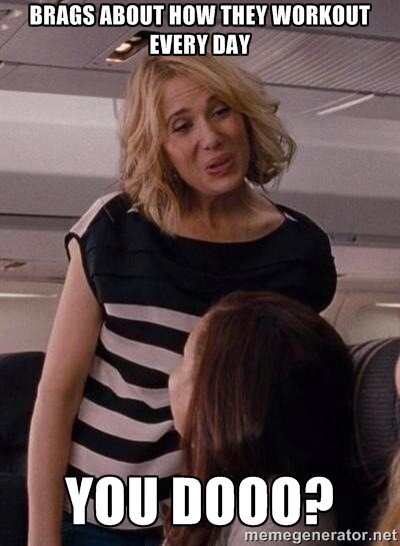

In [9]:
train_dataset[100]['image']

## Training Loop
We first define the data collator which takes list of samples and return input tensors fed to the model. There are 4 tensors types we are interested:
- input_ids : these are the input indices fed to the language model
- attention_mask : the attention mask for the input_ids in the language model
- pixel_values : the (pre-processed) pixel values that encode the image(s). Idefics2 treats images in their native resolution (up to 980) and their native aspect ratio
- pixel_attention_mask: when multiple image(s) are packed into the same sample (or in the batch), attention masks for the images are necessary because of these images can have different sizes and aspect ratio. This masking ensures that the vision encoder properly forwards the images.


In [16]:
import torch
class MyDataCollator:
    """
    Custom data collator to process and tokenize multimodal data (text + images).
    """
    def __init__(self, processor):
        self.processor = processor

    def __call__(self, examples):
        """
        Process a batch of examples into tokenized inputs and labels.
        """
        texts = []
        images = []
        assistant_responses = []  # Track assistant responses to mask correctly
        max_tokens = 2048

        for example in examples:
            image = example["image"]
            question = example["question"]
            answer = example["answer"]

            messages = [
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": question},
                        {"type": "image"},
                    ]
                },
                {
                    "role": "assistant",
                    "content": [
                        {"type": "text", "text": answer}
                    ]
                }
            ]

            # Convert to prompt using the processor’s template
            text = self.processor.apply_chat_template(messages, add_generation_prompt=False, tokenize=False)

            texts.append(text.strip())
            images.append(image)
            assistant_responses.append(answer)

        # Tokenize and process batch
        batch = self.processor(text=texts, images=images, return_tensors="pt",padding=True)

        # Prepare labels (we'll mask non-assistant tokens for loss computation)
        labels = batch["input_ids"].clone()

        # For each example, find the assistant tokens and mask the rest
        for i, (input_ids, assistant_response) in enumerate(zip(batch["input_ids"], assistant_responses)):
            # Tokenize just the assistant response
            assistant_tokens = self.processor.tokenizer(
                assistant_response, return_tensors="pt", truncation=True, max_length=512
            )["input_ids"][0][1:]  # remove BOS token

            # Find where the assistant tokens begin
            start_idx = self.find_subsequence(input_ids, assistant_tokens)

            if start_idx is not None:
                # Mask everything before the assistant response
                labels[i, :start_idx] = -100
                # Optionally mask anything after the assistant response
                labels[i, start_idx + len(assistant_tokens):] = -100
            else:
                # If not found, mask everything
                labels[i] = -100

        batch["labels"] = labels
        return batch
    
    def find_subsequence(self, sequence, subsequence):
        """
        Helper function to find the starting index of a subsequence within a sequence.
        """
        seq_len = len(sequence)
        sub_len = len(subsequence)
        for i in range(seq_len - sub_len + 1):
            if torch.equal(sequence[i:i+sub_len], subsequence):
                return i
        return None
data_collator = MyDataCollator(processor)  # Initialize the custom data collator

In [17]:
sample_batch = [train_dataset[i] for i in range(2)]
processed_batch = data_collator(sample_batch)

print("Processed batch keys:", processed_batch.keys())
print("\nTokenized input IDs (before padding):")
print(processed_batch["input_ids"])

print("\nLabels (before masking):")
print(processed_batch["labels"])

# Decode tokens to readable text
for input_id in processed_batch["input_ids"]:
    print("\nDecoded Prompt:")
    print(processor.tokenizer.decode(input_id, skip_special_tokens=False))


Processed batch keys: dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'pixel_values', 'image_sizes', 'labels'])

Tokenized input IDs (before padding):
tensor([[   2,    2,    2,  ..., 3074, 6048,    2],
        [   1,    3, 5242,  ..., 3074, 6048,    2]])

Labels (before masking):
tensor([[-100, -100, -100,  ..., -100, -100, -100],
        [-100, -100, -100,  ..., -100, -100, -100]])

Decoded Prompt:
</s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s><s>[INST]Classify the text <whew ... that extra <num> miles today to the grocery store & back wore me out . so why are you using a car ?> and the image into one of the following categories: <SARCASTIC, NOT SARCASTIC>.
[IMG][IMG][IMG][IMG][IMG][

In [18]:
processed_batch = data_collator(train_dataset)  # Process the training dataset

# Print processed batch keys for debugging
print("Processed batch keys:", processed_batch.keys())
print("\nTokenized input IDs (before padding):")
print(processed_batch["input_ids"])

# Decode tokens to readable text
# for input_id in processed_batch["input_ids"]:
#     print("\nDecoded Prompt:")
#     print(processor.tokenizer.decode(input_id, skip_special_tokens=False))


ValueError: Unable to create tensor, you should probably activate padding with 'padding=True' to have batched tensors with the same length.

In [14]:
print(model)

LlavaForConditionalGeneration(
  (model): LlavaModel(
    (vision_tower): PixtralVisionModel(
      (patch_conv): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16), bias=False)
      (ln_pre): PixtralRMSNorm((1024,), eps=1e-05)
      (transformer): PixtralTransformer(
        (layers): ModuleList(
          (0-23): 24 x PixtralAttentionLayer(
            (attention_norm): PixtralRMSNorm((1024,), eps=1e-05)
            (feed_forward): PixtralMLP(
              (gate_proj): Linear(in_features=1024, out_features=4096, bias=False)
              (up_proj): Linear(in_features=1024, out_features=4096, bias=False)
              (down_proj): Linear(in_features=4096, out_features=1024, bias=False)
              (act_fn): GELUActivation()
            )
            (attention): PixtralAttention(
              (k_proj): Linear(in_features=1024, out_features=1024, bias=False)
              (v_proj): Linear(in_features=1024, out_features=1024, bias=False)
              (q_proj): Linear(in_feature

In [22]:
lora_config = LoraConfig(
    r=16,  # Rank - Higher values for larger datasets
    lora_alpha=16,  # Scaling factor for LoRA
    use_rslora=True,  # Use RS-LoRA for better performance
    target_modules=['gate_proj'], 
    lora_dropout=0.1,  # Dropout rate for LoRA
    bias="none",  # No bias adjustment
    task_type="CAUSAL_LM"  # Task type: Causal Language Modeling
)

# Wrap the model with LoRA configuration
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()  # Print trainable parameters for debugging

IndexError: list index out of range

In [ ]:
# Training configuration
epochs = 3  # Number of training epochs
lr = 3e-5  # Learning rate
schedule = "constant"  # Learning rate schedule

training_args = TrainingArguments(
    # num_train_epochs=epochs,
    max_steps=30,
    per_device_train_batch_size=3,  # Batch size per device for training
    per_device_eval_batch_size=1,  # Batch size per device for evaluation
    gradient_accumulation_steps=1,  # Accumulate gradients over multiple steps
    learning_rate=lr,
    weight_decay=0.01,  # Weight decay for regularization
    logging_steps=0.1,  # Log every 0.1 steps
    output_dir="pixtral_output", # Output directory for saving the model
    eval_strategy="steps",  # Evaluation strategy
    eval_steps=0.2,  # Evaluate every 0.2 steps
    lr_scheduler_type=schedule,  # Learning rate scheduler type
    bf16=True,  # Use bfloat16 precision
    remove_unused_columns=False,  # Keep all columns in the dataset
    gradient_checkpointing=True,  # Enable gradient checkpointing
    gradient_checkpointing_kwargs={'use_reentrant': True}  # Additional checkpointing options
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    processing_class=processor.tokenizer  # Tokenizer for processing
)

trainer.train()  # Start training
